In [1]:
# Core scientific stack
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os
from glob import glob

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, colors, cbook
import seaborn as sns
import cmocean as cmocn  # if you want it; comment out if not used

# Machine Learning
from sklearn.cluster import DBSCAN, OPTICS, KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             silhouette_score,
                             pairwise_distances)
from imblearn.over_sampling import SMOTE

# Scipy
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d

# Parallelism
from joblib import Parallel, delayed

# Tensorflow
import tensorflow as tf

%matplotlib inline

2025-07-10 19:37:06.547075: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 19:37:06.559603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752190626.572934 1537168 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752190626.576885 1537168 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752190626.587789 1537168 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
# dsA = xr.open_dataset(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_A.nc')
# dsB = xr.open_dataset(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_B.nc')
# dsB['count'] = dsB['count'] + np.max(dsA['count'].to_numpy()) + 1

# ds = xr.concat([dsA, dsB], dim='count')

ds = xr.open_dataset('../../seaStateProcessing/testMatchups/rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_AB_waveAndGlorysAdded.nc')
df = ds.to_dataframe()
df['SST - AIRT'] = df['Sea Surface Temperature (TAO)'] - df['Air Temperature (TAO)']
#df = df.dropna(how='any')
df_orig = df.copy()

In [5]:
from tensorflow.keras.models import load_model
model = load_model('../../seaStateProcessing/deepLearning/my_tf_model.h5')

In [6]:
data = df
data = data.rename(columns = {'SST - AIRT' :'SST-AIRT'})
# Features to use for classification
features = ['std_cosWDIR', 
            'std_sinWDIR',
            'SST-AIRT',
            'mean_SST - AIRT',
            'std_SST - AIRT', 
            'Relative Humidity (TAO)',             
            'mean_RELH',             
            'mean_SST',
            'std_AIRT',
            'std_SST', 
            'mean_AIRT',
            'std_RELH',
            'Neutral Wind Speed at 10m (TAO)',
            'std_WSPD', 
            'mean_WSPD',
            'mean_WSPD_10N',
            'std_WSPD_10N',
            #'model_speed',
            #'model_dir',
            'VHM0',
             'VHM0_SW1',
             'VHM0_SW2',
             'VHM0_WW',
             'VMDR',
             'VMDR_SW1',
             'VMDR_SW2',
             'VMDR_WW',
             'VPED',
             'VSDX',
             'VSDY',
             'VTM01_SW1',
             'VTM01_SW2',
             'VTM01_WW',
             'VTM02',
             'VTM10',
             'VTPK',
             'vo',
             'zos',
             'uo',
             'thetao',
             'so'
           ]

X = data[features]

In [7]:
from sklearn.preprocessing import StandardScaler


X_train_bal = np.load('../../seaStateProcessing/deepLearning/X_train.npy')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_bal) # Fit on training data
X_test_scaled = scaler.transform(X)  # Now can transform test data

/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [8]:
# Predictions
y_pred_prob = model.predict(X_test_scaled).flatten()


I0000 00:00:1752190641.340589 1537295 service.cc:152] XLA service 0x7f2a700052e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752190641.340622 1537295 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-07-10 19:37:21.353015: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752190641.405442 1537295 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-10 19:37:22.933686: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 24 bytes spill stores, 24 bytes spill loads

2025-07-10 19:37:23.373035: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20', 24 bytes 

  72/2207 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

I0000 00:00:1752190644.145364 1537295 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2207/2207 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step


In [13]:
y_pred = (y_pred_prob > 0.).astype(int)

df['predicted_label'] = y_pred

/tmp/ipykernel_1537168/3763951007.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_1537168/3763951007.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(df, x='predicted_label',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_1537168/3763951007.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(df, x='predicted_label',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


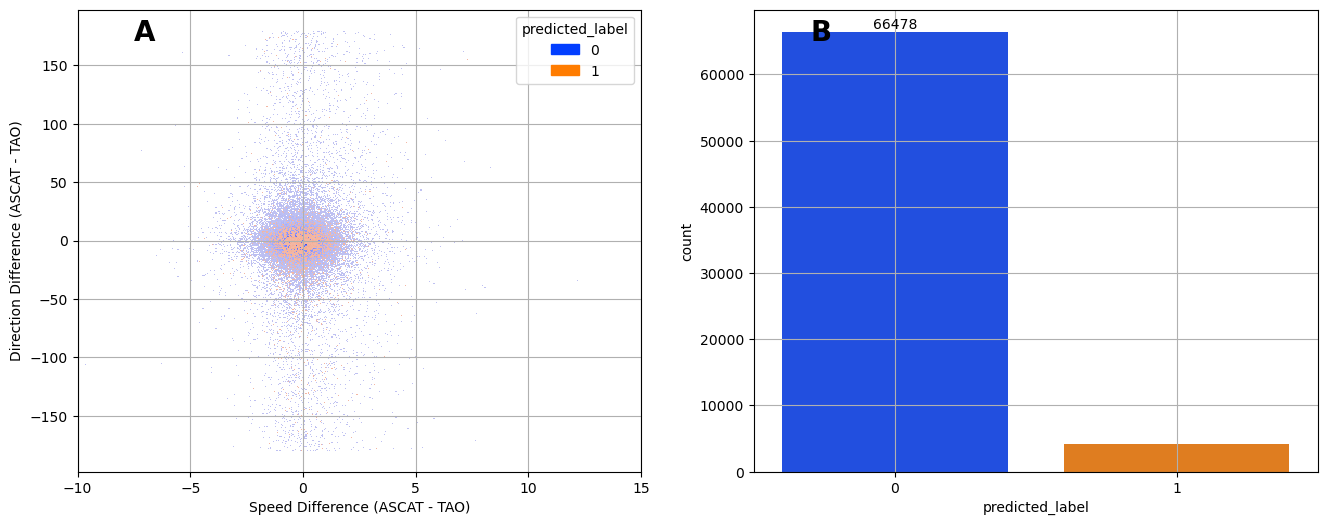

In [14]:

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (ASCAT - TAO)'
ylabel = 'Direction Difference (ASCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='predicted_label', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='predicted_label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
#ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

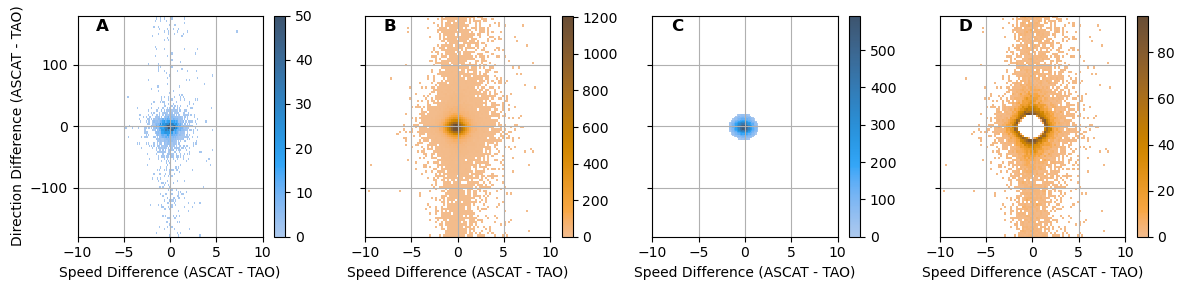

In [15]:
selectX = ['Speed Difference (ASCAT - TAO)',
          'cos(Direction Difference (ASCAT - TAO))',
          'sin(Direction Difference (ASCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.21, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

fig,  axes = plt.subplots(nrows = 1, ncols = 4, figsize=(12,3), sharex = True, sharey = True)
labelFS = 12



ax = axes[0]
s = sns.histplot( df.loc[df["predicted_label"] == 1], x=xlabel, y = ylabel, bins = (100,100), cbar = True, ax = ax)
ax.set_xlim(-10,10)
ax.set_ylim(-180,180)
ax.grid()
ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)

ax = axes[1]
s = sns.histplot( df.loc[df["predicted_label"] == 0], x=xlabel, y = ylabel, bins = (100,100), color = 'orange', cbar = True, ax = ax)
ax.set_xlim(-10,10)
ax.set_ylim(-180,180)
ax.grid()
ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)

ax = axes[2]
s = sns.histplot( df.loc[df["label"] == 0], x=xlabel, y = ylabel, bins = (20,20), cbar = True, ax = ax)
ax.set_xlim(-10,10)
ax.set_ylim(-180,180)
ax.grid()
ax.text(0.1, 0.95, 'C', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)

ax = axes[3]
s = sns.histplot( df.loc[df["label"] == -1], x=xlabel, y = ylabel, bins = (100,100), color = 'orange', cbar = True, ax = ax)
ax.set_xlim(-10,10)
ax.set_ylim(-180,180)
ax.grid()
ax.text(0.1, 0.95, 'D', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)

plt.tight_layout()
#plt.savefig('goodBadMatchupPredictedOnASCATtrainedOnQuikSCAT.pdf', dpi=100)

In [16]:
from sklearn.metrics import classification_report, accuracy_score
y_test = df["label"] + 1
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.26650235140801176

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.94      0.38     16650
           1       0.76      0.06      0.11     53946

    accuracy                           0.27     70596
   macro avg       0.50      0.50      0.24     70596
weighted avg       0.64      0.27      0.17     70596



In [ ]:
def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['Wind Speed (ASCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

def getDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        QSdir = subDF['Wind Direction (ASCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getXSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Zonal Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Ux_10N {timeWindow}min'
        QSspeed_x = subDF['Zonal Wind Speed (ASCAT)']
        TAOspeed_x = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_x, TAOspeed_x)[0,1]
        return corr
    else:
        return -999

def getYSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
        if timeWindow == 10:
            TAOlabel = 'Meridional Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Vy_10N {timeWindow}min'
    if isPresent:
        QSspeed_y = subDF['Meridional Wind Speed (ASCAT)']
        TAOspeed_y = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_y, TAOspeed_y)[0,1]
        return corr
    else:
        return -999


goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['predicted_label'].isin([0])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

In [ ]:
selectX = ['Speed Difference (ASCAT - TAO)',
          'cos(Direction Difference (ASCAT - TAO))',
          'sin(Direction Difference (ASCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.21, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import pandas as pd

# Example DataFrame: df must contain 'label', 'speed', 'direction'
# Replace these with your actual column names
xlabel = 'Speed Difference (ASCAT - TAO)'
ylabel = 'Direction Difference (ASCAT - TAO)'

# Compute mean and std
mu_speed = df[xlabel].mean()
std_speed = df[xlabel].std()
mu_dir = df[ylabel].mean()
std_dir = df[ylabel].std()

# Create overall figure
fig = plt.figure(figsize=(13, 10))
gs = gridspec.GridSpec(4, 8, width_ratios=[3, 0.8, 0.1, 0.1, 0.25, 0.1, 0.75, 1], height_ratios=[0.75, 3, 0.75, 2], wspace=0, hspace=0)

# Joint and marginals (LEFT)
ax_joint = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)
ax_cb1 = fig.add_subplot(gs[1,3])
ax_cb2 = fig.add_subplot(gs[1,5])

# Countplot (RIGHT)
ax_count = fig.add_subplot(gs[0:2, -1])  # spans both rows

# -------------------------
# 1. JOINT HISTOGRAM + KDE

colors = [plt.cm.Blues, plt.cm.Oranges]
hexcounts = [100, 100]
x_min, x_max, y_min, y_max = -5, 5, -100, 100
vmins = [0, 0]
vmaxs = [30, 220]
numcontours = 5

for i, (label, ax, ax_cb) in enumerate(zip([-1, 0], [ax_joint, ax_joint], [ax_cb1, ax_cb2])):
    df_label = df[df['label'] == label]

    hb = ax.hexbin(
        x=df_label[xlabel],
        y=df_label[ylabel],
        gridsize=hexcounts[i],
        cmap=colors[i],
        mincnt=1,
        linewidths=0.01,
        edgecolors=(0, 0, 0, 0.01),
        vmin=vmins[i],            # ← custom lower limit
        vmax=vmaxs[i],             # ← custom upper limit
        extent=(x_min, x_max, y_min, y_max)
    )

    # Extract colorbar for this label
    cbar = fig.colorbar(hb, cax=ax_cb)
    
#cbar.set_label("Bin Count")
cbar.ax.text(
    0.6, 1.05,                        # x=50% of width, y=just above the top
    "Bin Count",                     # your label
    ha='right', va='bottom',        # horizontal center, baseline aligned
    fontsize=10, fontweight='bold',  # optional styling
    transform=cbar.ax.transAxes      # relative to colorbar axis
)

# Create the Joint PDF plot and capture the returned QuadContourSet object
# KDE Grid resolution
nx, ny = 64, 64

# Data
x = df[xlabel].values
y = df[ylabel].values
xy = np.vstack([x, y])

# KDE with specified bandwidth
kde = gaussian_kde(xy, bw_method=0.1)

# Grid over which to evaluate
xx, yy = np.mgrid[x_min:x_max:nx*1j, y_min:y_max:ny*1j]
grid_coords = np.vstack([xx.ravel(), yy.ravel()])
z = kde(grid_coords).reshape(xx.shape)

# Normalize z to make it a probability surface (area ≈ 1)
dx = (x_max - x_min) / nx
dy = (y_max - y_min) / ny
z_prob = z / z.sum() #/ (dx * dy)

# Flatten and sort to get cumulative distribution
z_flat = z_prob.flatten()
z_sorted = np.sort(z_flat)[::-1]  # 🔄 descending order
z_cumsum = np.cumsum(z_sorted)

# Desired probability masses for contours
mass_levels = [0.1, 0.5, 0.68, 0.8, 0.95]
mass_levels.reverse()
levels = [z_sorted[np.searchsorted(z_cumsum, mass)] for mass in mass_levels]


#levels.sort()
# Plot contours
contour = ax_joint.contour(xx, yy, z_prob, levels=levels, colors='black', linewidths=0.8)

# Label with probability instead of density
fmt = {}
for l, s in zip(contour.levels, mass_levels):
    fmt[l] = f"{s:.3f}"  # show enclosed probability

#fmt = {level: f"{mass:.3f}" for level, mass in zip(levels, mass_levels)}

ax_joint.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=8)
# # Add labels to the contour lines
# ax_joint.clabel(contour, inline=True, fontsize=8, fmt="%.2f")

# 2. MARGINAL KDEs
sns.kdeplot(data=df, x=xlabel, fill=True, legend=False, ax=ax_marg_x, clip = (x_min, x_max) , cut = 0, bw_adjust=0.5 )
sns.kdeplot(data=df, y=ylabel, fill=True, legend=False, ax=ax_marg_y, clip = (y_min, y_max) , cut = 0, bw_adjust=0.5 )

# Remove marginal axis ticks
ax_marg_x.tick_params(bottom=False, labelbottom=False)
ax_marg_y.tick_params(left=False, labelleft=False)

# Add ±1σ lines
for x in [mu_speed - std_speed, mu_speed, mu_speed + std_speed]:
    ax_joint.axvline(x, color='red', linestyle='--', linewidth=1)
    ax_marg_x.axvline(x, color='red', linestyle='--', linewidth=1)  
    ax_marg_x.set_yticks([0.2,0.4])

for y in [mu_dir - std_dir, mu_dir, mu_dir + std_dir]:
    ax_joint.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.set_xticks([0.02,0.04])


# Axis labels
ax_joint.set_xlabel(xlabel + ' [m/s]')
ax_joint.set_ylabel(ylabel + " (°)")
ax_marg_x.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_marg_y.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_marg_x.set_xlabel(None)
ax_marg_y.set_ylabel(None)

# Label the panel
ax_joint.text(0.05, 0.95, 'A. (i)', transform=ax_joint.transAxes, fontsize=16, weight='bold')
ax_marg_x.text(0.05, 0.80, 'A. (ii)', transform=ax_marg_x.transAxes, fontsize=16, weight='bold')
ax_marg_y.text(0.05, 0.95, 'A. (iii)', transform=ax_marg_y.transAxes, fontsize=16, weight='bold')

# -------------------------
# 3. COUNTPLOT
s = sns.countplot(data=df, x='label', palette='bright', ax=ax_count)
s.bar_label(s.containers[0])
ax_count.set_title("Cluster Label Counts")
#ax_count.set_xticks([-1, 0])                    # positions (the actual cluster labels)
ax_count.set_xticklabels(["Bad", "Good"])       # the new labels shown on the axis
ax_count.set_xlabel("Matchup Quality")
ax_count.set_ylabel("Count")
ax_count.text(0.05, 0.95, 'B.', transform=ax_count.transAxes, fontsize=16, weight='bold')

# Final adjustments

ax_joint.set_xlim(x_min, x_max)
ax_joint.set_ylim(y_min,  y_max)
ax_joint.grid(lw = 0.2)

ax_marg_x.set_xlim(x_min, x_max)
ax_marg_x.grid(lw = 0.2)

ax_marg_y.set_ylim(y_min,  y_max)
ax_marg_y.grid(lw = 0.2)

######################################################################################################################

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
dotSize = 60
slw = 0.1

latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

ax = fig.add_subplot(gs[3,:], projection=ccrs.PlateCarree(central_longitude=180))
ax.set_aspect(1.2)

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        txt = f'{badPercent:2.0f}'
        ax.text(xpos+2, lat-0.5, txt)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, badPercent]])), axis = 0)

x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C. ', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


plt.tight_layout()

#plt.savefig('clustering.pdf', dpi=100)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
# Evaluate the classifier performance
y_test, y_pred = df['label']+1, df['predicted_label']
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=50, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

###################################################################################################################
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.5, vmax=0.95, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


###################################################################################################################
ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, df)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.40, vmax=0.85, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


In [ ]:
df['SST - AIRT (TAO)'] = df['Sea Surface Temperature (TAO)'] - df['Air Temperature (TAO)']

fig, axes = plt.subplots(nrows=4, ncols =6, sharex = False, figsize=(25,16))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(65,100,50)
custom_bins_SST = np.linspace(20,32,50)
custom_bins_AIRT = np.linspace(15,32,50)
custom_bins_U10x = np.linspace(-15,10,50)
ny = 10
stack_order = {'good', 'bad'}

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. a)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)



xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[0,1]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. b)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel = 'SST - AIRT (TAO)'
ax = axes[0,2]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. c)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel = 'std. dev. WSPD 120min'
ax = axes[0,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. d)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. cosWDIR 120min'
ax = axes[0,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. e)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. sinWDIR 120min'
ax = axes[0,5]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. f)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. a)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[1,1]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. b)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel = 'SST - AIRT (TAO)'
ax = axes[1,2]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. c)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)



xlabel = 'std. dev. WSPD 120min'
ax = axes[1,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. d)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. cosWDIR 120min'
ax = axes[1,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. e)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. sinWDIR 120min'
ax = axes[1,5]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. f)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


################################################################################################
xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon > -120 E '

ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. a)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)
#ax.text(-0.01, 0.33, 'Eastern Pacific', transform=ax.transAxes, rotation=90)


xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[2,1]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. b)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'SST - AIRT (TAO)'
ax = axes[2,2]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. c)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel = 'std. dev. WSPD 120min'
ax = axes[2,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. d)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. cosWDIR 120min'
ax = axes[2,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. e)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. sinWDIR 120min'
ax = axes[2,5]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. f)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


################################################################################################
################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[3,0]
subDF = df.copy()
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. a)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[3,1]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. b)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'SST - AIRT (TAO)'
ax = axes[3,2]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=True,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. c)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. WSPD 120min'
ax = axes[3,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. d)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. cosWDIR 120min'
ax = axes[3,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. e)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. sinWDIR 120min'
ax = axes[3,5]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. f)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.legend()

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.25, hspace=0.25)
#plt.savefig('StackedHistogram.png', dpi = 100)